# Lorenz system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from __future__ import division
from numpy.linalg import qr
%matplotlib notebook

In [2]:
## Lorenz System
def Lorenz(X,a=10,b=28,c=8/3):
    dX = np.ndarray(X.shape)
    dX[0] = a*(X[1]-X[0])
    dX[1] = X[0]*(b-X[2])-X[1] 
    dX[2] = X[0]*X[1]-c*X[2]
    return dX

# Lorenz Jacobian
def J_Lo(X,a=10,b=28,c=8/3):
    return np.array([[-a, a, 0 ], [b-X[2],-1,-X[0]], [X[1],X[0],-c]])

In [3]:
# integrate trajectory and compute first k Lyap Exponents

# params
num_steps = 100000
dt = 0.001
k = 3 # number of LEs to compute
x0 = np.array([-10,-10,20])
Y0 = np.eye(3)

# containers
x_traj = np.empty([num_steps,3])
x_traj[0,:] = x0
running_logs = np.zeros([k,num_steps-1])

# integration
n=0
Q = Y0[:,:k]
while n<num_steps-1:
    n+=1
    x_traj[n,:] = x_traj[n-1,:]+dt*Lorenz(x_traj[n-1]) # integrate solution
    Z = Q+dt*np.matmul(J_Lo(x_traj[n-1,:]),Q)
    Q,R = qr(Z)
    running_logs[:,n-1] = np.log(abs(np.diag(R)))

Text(0.5,1,'Lyapunov Exponents')

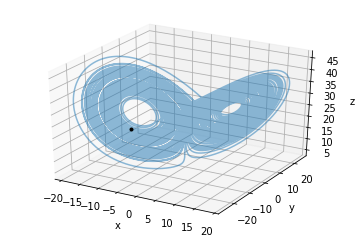

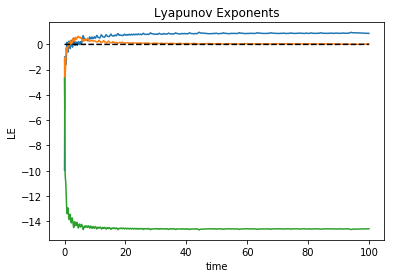

In [4]:
# plots

# trajectory
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x_traj[:,0], x_traj[:,1],x_traj[:,2],alpha=0.5)
ax.plot3D(x_traj[:1,0], x_traj[:1,1],x_traj[:1,2],'k.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# LE convergence traces
running_div = np.array([n*dt for n in range(1,num_steps)])
plt.figure();
for i in range(k):
    plt.plot(running_div,np.cumsum(running_logs[i,:])/running_div)
plt.plot(running_div,0*running_div,'k--')
plt.xlabel('time');
plt.ylabel('LE');
plt.title('Lyapunov Exponents')

In [5]:
# Check computation
LE_spectrum = running_logs.sum(axis=1)/(num_steps*dt)
print('Lyapunov exponents: %.3f, %.3f, %.3f' %(LE_spectrum[0],LE_spectrum[1],LE_spectrum[2]))
print('Sum of LEs: %.3f, mean det|J|: %.3f' %(LE_spectrum.sum(), np.trace(J_Lo(x0))))


Lyapunov exponents: 0.871, 0.032, -14.604
Sum of LEs: -13.701, mean det|J|: -13.667


In [6]:
entropy = LE_spectrum[:1].sum()
k = [LE_spectrum>0][0].sum()
dimension = k+LE_spectrum[:k].sum()/abs(LE_spectrum[k])
print('Entropy: %.2f (nats/time-unit), Dimension: %.2f' %(entropy,dimension))

Entropy: 0.87 (nats/time-unit), Dimension: 2.06


## Cross correlation of dynamics
One expects the cross-correlation of any x_i(t) from a chaotic system to exponentially decay at about a rate of -1/\lambda_1.

Text(0.5,0,'time-delay tau')

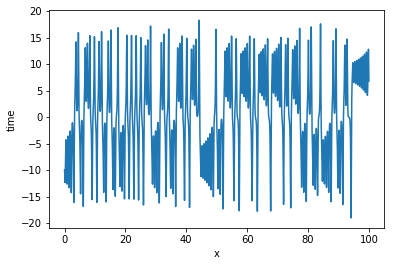

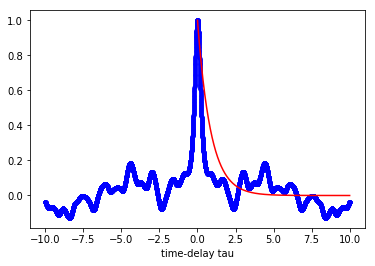

In [7]:
# pick a coordinate and extract time-series
x = x_traj[:,0]
time_traj = np.array([i*dt for i in range(num_steps)])

# plot trajectory in chosen coordinate
plt.figure()
plt.plot(time_traj, x_traj[:,0])
plt.xlabel('x')
plt.ylabel('time')


# compute (normalized) cross-correlation of time-series
cor = np.correlate(x,x,mode='full')
mid = (len(cor)-1)/2+1
lag=10000
cor = cor[int(mid-lag):int(mid+lag)]/cor[int(mid)]
c_time = np.linspace(-lag,lag,len(cor))*dt

# plot cross-corr along with exp(-t/\lambda_1)
plt.figure()
plt.plot(c_time,cor,'b.')
s = np.linspace(0,10,1000) # time points to plot exponential decay
plt.plot(s,np.exp(-1/LE_spectrum[0]*s),'r')
plt.xlabel('time-delay tau')

## Delay embedding of strange attractor
Will implement a 3D embedding of Lorenz attractor only using scalar time-series of trajectory

Text(0.5,0.92,'embedding for delay tau= 0.050')

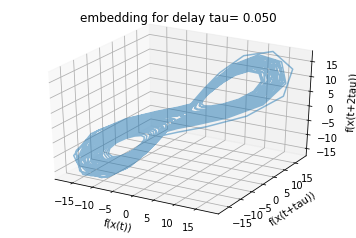

In [8]:
# uses trajectory x_traj generated above

# params
tau = 50 # delay for embedding
coord = 0 # 0,1,2: readout scalar coordinate to use as time-series
num_pts = 1000 # number of points to keep

# delayed 3D embedding
X = x_traj[::tau,coord][:num_pts]
Y = x_traj[tau::tau,coord][:num_pts]
Z = x_traj[2*tau::tau,coord][:num_pts]

# 3D plot of embedding
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(X, Y, Z, alpha=0.5)
# ax.plot3D(x_traj[:1,0], x_traj[:1,1],x_traj[:1,2],'k.')
ax.set_xlabel('f(x(t))')
ax.set_ylabel('f(x(t+tau))')
ax.set_zlabel('f(x(t+2tau))')
ax.set_title('embedding for delay tau= %.3f' %(dt*tau))


## Finite-time Lyapunov Exponents
Compute FTLEs for a 2-D grid of initial conditions for the Lorenz system

In [13]:
# integrate trajectory and compute first k Lyap Exponents

# spatial params
x0_grid = np.linspace(-20,20,10)
y0_grid = np.linspace(-20,20,10)
z0 = 20
X0,Y0 = np.meshgrid(x0_grid,y0_grid)

# temporal params
num_steps = 100
dt = 0.001
k = 2 # number of LEs to compute
x0 = np.array([-10,-10,20])
Y0 = np.eye(3)

# containers
FTLE = np.zeros([len(x0_grid),len(y0_grid),k,num_steps-1])
TRAJS = np.zeros([len(x0_grid),len(y0_grid),num_steps,3])

# integration
for ix, x0 in enumerate(x0_grid):
    for iy, y0 in enumerate(y0_grid):
        X0 = np.array([x0,y0,z0])
        Y0 = np.eye(3)
        # containers
        running_logs = np.zeros([k,num_steps-1])
        TRAJS[ix,iy,0,:] = X0
        n=0
        Q = Y0[:,:k]
        while n<num_steps-1:
            n+=1
            TRAJS[ix,iy,n,:] = TRAJS[ix,iy,n-1,:]+dt*Lorenz(TRAJS[ix,iy,n-1,:]) # integrate solution
            Z = Q+dt*np.matmul(J_Lo(TRAJS[ix,iy,n-1,:]),Q)
            Q,R = qr(Z)
            running_logs[:,n-1] = np.log(abs(np.diag(R)))
            FTLE[ix,iy,:,n-1] = np.sum(running_logs,axis=1)/(n*dt)

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

def slider_plot(slider):
    slider = int(slider)
    # plot
    plt.figure(figsize=(15,8));
    # trajectories
    axV = plt.subplot(1,2,1);
    for ix in range(len(x0_grid)):
        for iy in range(len(y0_grid)):
            axV.plot(TRAJS[ix,iy,0,0],TRAJS[ix,iy,0,1],'k.');
            axV.plot(TRAJS[ix,iy,:slider,0],TRAJS[ix,iy,:slider,1],'b');
    axV.set_title('trajectory in 2D');
    axV.set_ylabel('y');
    axV.set_xlabel('x');
    plt.xlim([-30,30]);
    plt.ylim([-30,30]);
    # FTLEs
    axV = plt.subplot(1,2,2);
    c = axV.pcolor(x0_grid,y0_grid,FTLE[:,:,0,slider],vmin=-10,vmax=1)
    axV.set_title('FTLE');
    axV.set_ylabel('y');
    axV.set_xlabel('x');
    plt.colorbar(c, ax=axV)


    
    
interact(slider_plot, slider = widgets.FloatSlider(value=0,
                                               min=10,
                                               max=num_steps-2,
                                               step=10));

interactive(children=(FloatSlider(value=10.0, description='slider', max=98.0, min=10.0, step=10.0), Output()),…

In [11]:
FTLE.shape
num_steps

500